In [12]:
from constants import TIMBRE_GROUP
import h5py
import numpy as np
import matplotlib.pyplot as plt
from ipy_progressbar import ProgressBar
from collections import defaultdict
from tracks_to_assignments import get_anns
from constants import valid_data_types

%matplotlib notebook

# Approximate Nearest Neighbor objects
anns = get_anns()

## Overview: corpus size and features

In [25]:
track_count = 0
feature_counts = defaultdict(int)

with h5py.File('../tracks.h5', 'r') as tracks:
    for track, grp in ProgressBar(tracks.items()):
        any_valid = False
        for data_type, d in grp.items():
            n = d.shape[0]
            feature_counts[data_type] += n
            if n > 100:
                any_valid = True
        if any_valid:
            track_count += 1

print("Tracks: {}".format(track_count))
print(feature_counts)

Tracks: 559
defaultdict(<class 'int'>, {'beat_coefs': 39260, 'gfccs': 10488478, 'chroma': 10488478})



## Find distances from K-means to actual values

In [2]:
def normalize_dists(v):
    dists = np.asarray(v)
    return dists / np.max(dists)

In [3]:
dists_by_dtype = defaultdict(list)

with h5py.File('../tracks.h5', 'r') as tracks:
    for track, grp in ProgressBar(tracks.items()):
        for data_type, d in grp.items():
            values = d.value
            if data_type == TIMBRE_GROUP:
                values = values[:, 1:]
            for x in values:
                x_hat = anns[data_type].tree.get_nns_by_vector(x, 1, include_distances=True)
                if np.isnan(x_hat[1][0]):
                    continue
                dists_by_dtype[data_type].append(x_hat[1][0])

dists_by_dtype = {k: np.asarray(v) for k, v in dists_by_dtype.items()}

<IPython.core.display.Javascript object>


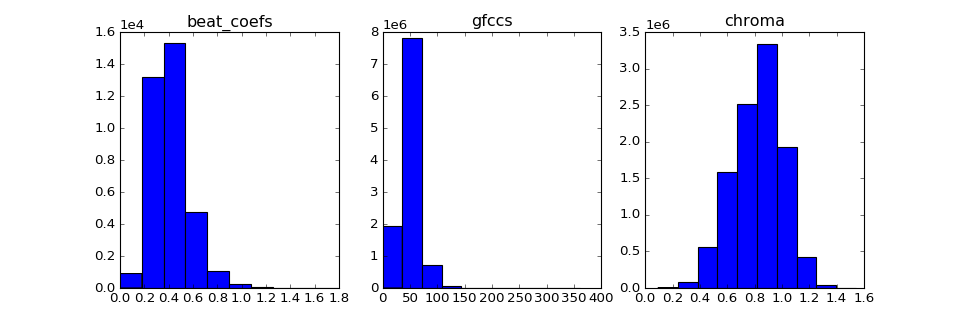

In [23]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
for i, (d_type, data) in enumerate(dists_by_dtype.items()):
    axs[i].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    axs[i].set_title(d_type)
    axs[i].hist(data)
plt.savefig('distanceFromKmeans.pdf')